# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of industrial crop production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
industrial_crop = pd.read_csv('./Italy_crop_data/italy_industrial_crop.csv',skipinitialspace=True)
industrial_crop.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC16,Cuneo,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2020,2020,350,NaN,NaN
1,ITC16,Cuneo,HP_Q_EXT,harvested production - quintals,PARSNGREEN,parsley in greenhouses,2020,2020,350,NaN,NaN
2,ITC16,Cuneo,ART_ARE,total area - ares,PARSNGREEN,parsley in greenhouses,2020,2020,155,NaN,NaN
3,ITC31,Imperia,TP_QUIN_EXT,total production - quintals,PARSNGREEN,parsley in greenhouses,2021,2021,125,NaN,NaN
4,ITC31,Imperia,HP_Q_EXT,harvested production - quintals,PARSNGREEN,parsley in greenhouses,2021,2021,110,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
industrial_crop = industrial_crop.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
industrial_crop

,Territory,Data type,Type of crop,Select time,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2020,350
1,Cuneo,harvested production - quintals,parsley in greenhouses,2020,350
2,Cuneo,total area - ares,parsley in greenhouses,2020,155
3,Imperia,total production - quintals,parsley in greenhouses,2021,125
4,Imperia,harvested production - quintals,parsley in greenhouses,2021,110
...,...,...,...,...,...
3315,Trentino Alto Adige / Südtirol,harvested production - quintals,hops,2021,60
3316,Grosseto,total area - hectares,other oilseed crops (excluding sesame),2021,72
3317,Udine,total area - hectares,hops,2021,1
3318,Arezzo,total area - hectares,other textile crops,2021,4


In [4]:
# Rename Columns
industrial_crop = industrial_crop.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(industrial_crop):
    print('DATASET SHAPE: ', industrial_crop.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(industrial_crop.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(industrial_crop.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(industrial_crop.isnull().sum())
show_info(industrial_crop)

DATASET SHAPE:  (3320, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3320 entries, 0 to 3319
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       3320 non-null   object
 1   Data_type  3320 non-null   object
 2   Type_crop  3320 non-null   object
 3   Year       3320 non-null   int64 
 4   Value      3320 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 129.8+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           98
Data_type       4
Type_crop      17
Year            3
Value        1174
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing industrial crop

In [6]:
#industrial_crop.City.unique()


In [7]:
industrial_crop.Data_type.unique()

array(['total production - quintals ', 'harvested production - quintals ',
       'total area - ares', 'total area - hectares'], dtype=object)

## Select only Values for total industrial crop production - quintals


In [8]:
industrial_crop_prod = industrial_crop[industrial_crop['Data_type'] == 'total production - quintals ']
industrial_crop_prod.head()

,City,Data_type,Type_crop,Year,Value
0,Cuneo,total production - quintals,parsley in greenhouses,2020,350
3,Imperia,total production - quintals,parsley in greenhouses,2021,125
6,Varese,total production - quintals,parsley in greenhouses,2020,5
9,Lecco,total production - quintals,parsley in greenhouses,2020,300
12,Milano,total production - quintals,parsley in greenhouses,2020,580


In [9]:
industrial_crop_prod = industrial_crop_prod.rename(columns = {'Value':'Total_production'})
industrial_crop_prod

,City,Data_type,Type_crop,Year,Total_production
0,Cuneo,total production - quintals,parsley in greenhouses,2020,350
3,Imperia,total production - quintals,parsley in greenhouses,2021,125
6,Varese,total production - quintals,parsley in greenhouses,2020,5
9,Lecco,total production - quintals,parsley in greenhouses,2020,300
12,Milano,total production - quintals,parsley in greenhouses,2020,580
...,...,...,...,...,...
3270,Campobasso,total production - quintals,"other aromatic, medicinal and culinary plants",2021,150
3276,Reggio di Calabria,total production - quintals,"other aromatic, medicinal and culinary plants",2021,95
3277,Caserta,total production - quintals,"other aromatic, medicinal and culinary plants",2021,33520
3312,Trentino Alto Adige / Südtirol,total production - quintals,hops,2020,50


In [10]:
industrial_crop_prod = industrial_crop_prod.drop(columns =['Data_type'])
industrial_crop_prod

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2020,350
3,Imperia,parsley in greenhouses,2021,125
6,Varese,parsley in greenhouses,2020,5
9,Lecco,parsley in greenhouses,2020,300
12,Milano,parsley in greenhouses,2020,580
...,...,...,...,...
3270,Campobasso,"other aromatic, medicinal and culinary plants",2021,150
3276,Reggio di Calabria,"other aromatic, medicinal and culinary plants",2021,95
3277,Caserta,"other aromatic, medicinal and culinary plants",2021,33520
3312,Trentino Alto Adige / Südtirol,hops,2020,50


## Total industrial crop production in 2020-2022

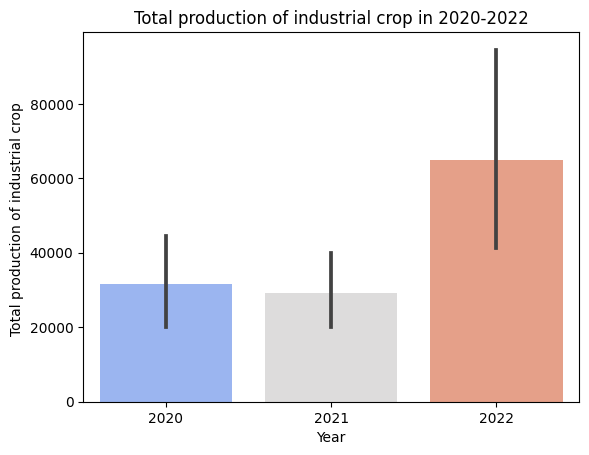

In [11]:

sns.barplot(x= 'Year', y= 'Total_production',data = industrial_crop_prod, palette='coolwarm')
plt.title('Total production of industrial crop in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of industrial crop ')
plt.show()



## Industrial crop production by Cities 

In [12]:
industrial_crop_prod_region = industrial_crop_prod.groupby(by = industrial_crop_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
industrial_crop_prod_region



,City,Total_production
92,Venezia,3531099
28,Ferrara,3500002
56,Padova,3221039
75,Rovigo,3148194
89,Udine,3094739
...,...,...
85,Trapani,240
77,Sassari,182
57,Palermo,180
16,Cagliari,122


In [13]:
region = industrial_crop_prod_region.nlargest(30, 'Total_production')

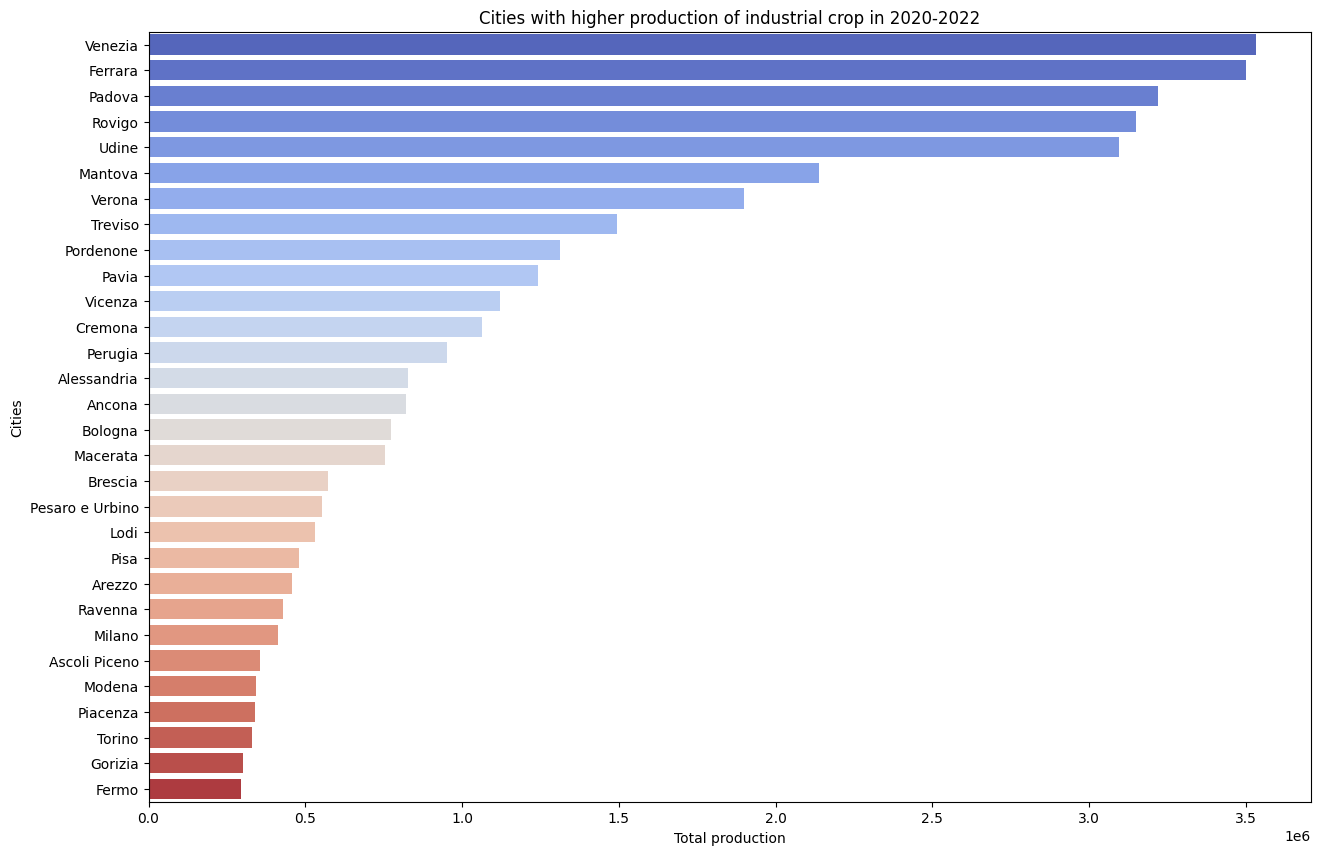

In [14]:
plt.figure(figsize= (15, 10))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Cities with higher production of industrial crop in 2020-2022')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show() 

##  Industrial crop  2020-2022

In [15]:
print(industrial_crop_prod.Type_crop.max())
print(industrial_crop_prod.Type_crop.value_counts())
print(industrial_crop_prod.Type_crop.nunique())



valerian in greenhouses
sunflower                                        216
rape                                             181
soya beans                                       179
hemp                                              93
parsley in open field                             86
sweet basil in greenhouses                        80
parsley in greenhouses                            70
tobacco                                           44
flax                                              36
hops                                              35
valerian in greenhouses                           32
groundnut                                         22
turnip rape                                       20
other aromatic, medicinal and culinary plants      8
sesame                                             2
other textile crops                                2
other oilseed crops (excluding sesame)             1
Name: Type_crop, dtype: int64
17


Dataset shows there are 17 different types of industrial crop cultivated in Italy. The top most produced crops are : Valerian, Greenhouses, Sunflower, Rape, Soya beans, Hemp, Parsley in open field, Sweet basil in greenhouses, Parsley in greenhouses, Tobacco, Flax. 


In [16]:
industrial_crop_prod.describe()

,Year,Total_production
count,1107.000000,1.107000e+03
mean,2020.774164,3.669004e+04
std,0.733801,1.378294e+05
min,2020.000000,0.000000e+00
25%,2020.000000,2.000000e+02
50%,2021.000000,1.387000e+03
75%,2021.000000,1.184100e+04
max,2022.000000,1.588837e+06


<AxesSubplot: >

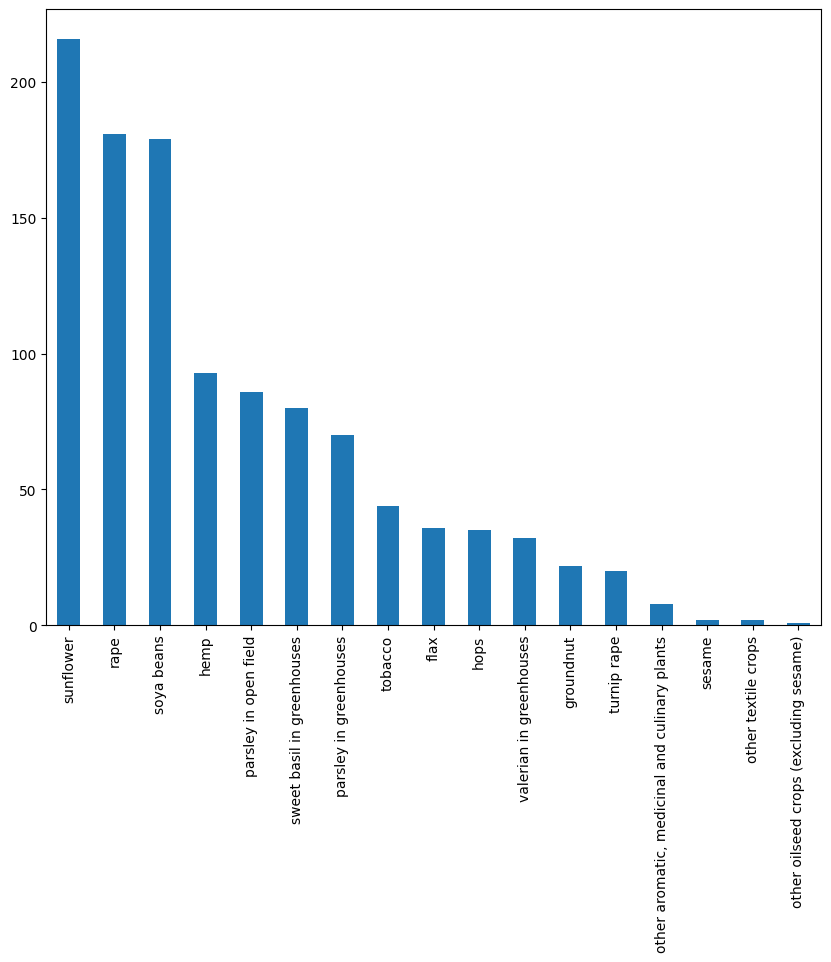

In [17]:
plt.figure(figsize=(10,8))
industrial_crop_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [18]:
industrial_crop_top10 = industrial_crop_prod.apply(lambda row: row[industrial_crop_prod['Type_crop'].isin(['valerian', 'greenhouses', 'sunflower', 'rape', 
                                                                                                           'soya beans', 'hemp', 'parsley in open field', 
                                                                                                           'sweet basil in greenhouses', 'parsley in greenhouses', 'tobacco', 'flax'])])

industrial_crop_top10.head()

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2020,350
3,Imperia,parsley in greenhouses,2021,125
6,Varese,parsley in greenhouses,2020,5
9,Lecco,parsley in greenhouses,2020,300
12,Milano,parsley in greenhouses,2020,580


## Stats

In [19]:
industrial_crop_top10.describe().astype(int)

,Year,Total_production
count,985,985
mean,2020,40972
std,0,145521
min,2020,0
25%,2020,330
50%,2021,1800
75%,2021,16875
max,2022,1588837


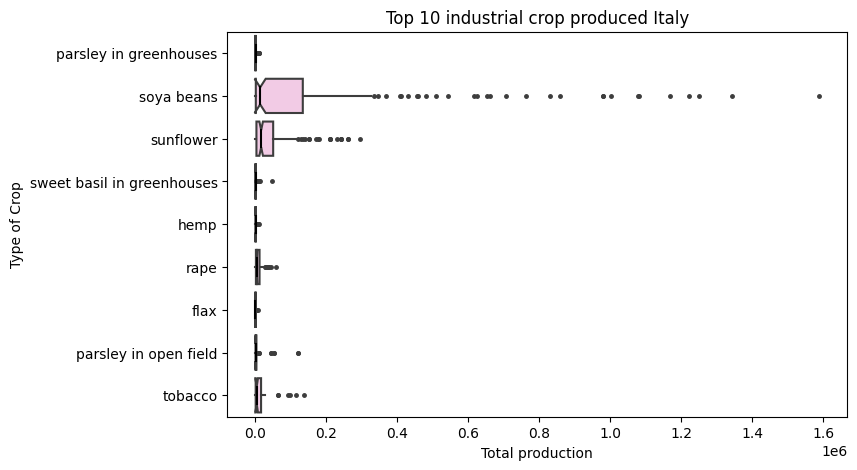

In [20]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=industrial_crop_top10, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 10 industrial crop produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

In [21]:
industrial_crop_top10

,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2020,350
3,Imperia,parsley in greenhouses,2021,125
6,Varese,parsley in greenhouses,2020,5
9,Lecco,parsley in greenhouses,2020,300
12,Milano,parsley in greenhouses,2020,580
...,...,...,...,...
3171,Trento,hemp,2020,50
3172,Trento,hemp,2021,60
3175,Sud Sardegna,parsley in greenhouses,2020,1461
3176,Sud Sardegna,parsley in greenhouses,2021,1461


## Vizualization of ten type of industrial crop produced in Italy in the period of 2020-2022 

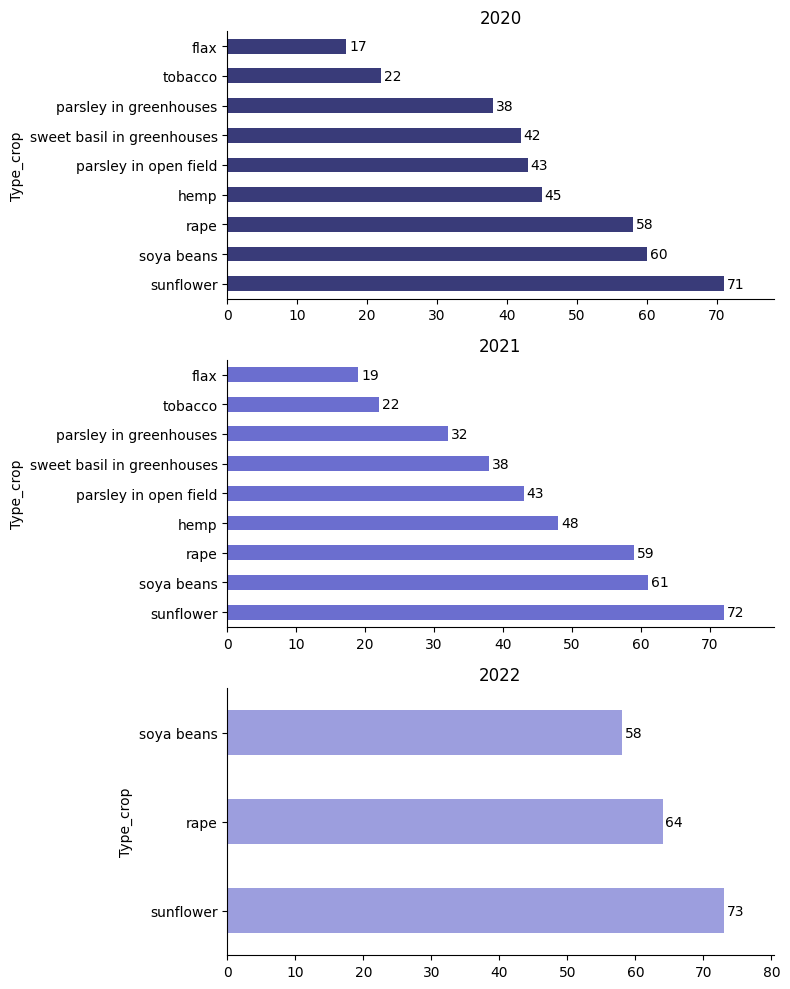

In [22]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = industrial_crop_top10[industrial_crop_top10.Year == 2020].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = industrial_crop_top10[industrial_crop_top10.Year == 2021].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = industrial_crop_top10[industrial_crop_top10.Year == 2022].groupby('Type_crop').size().nlargest(10).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

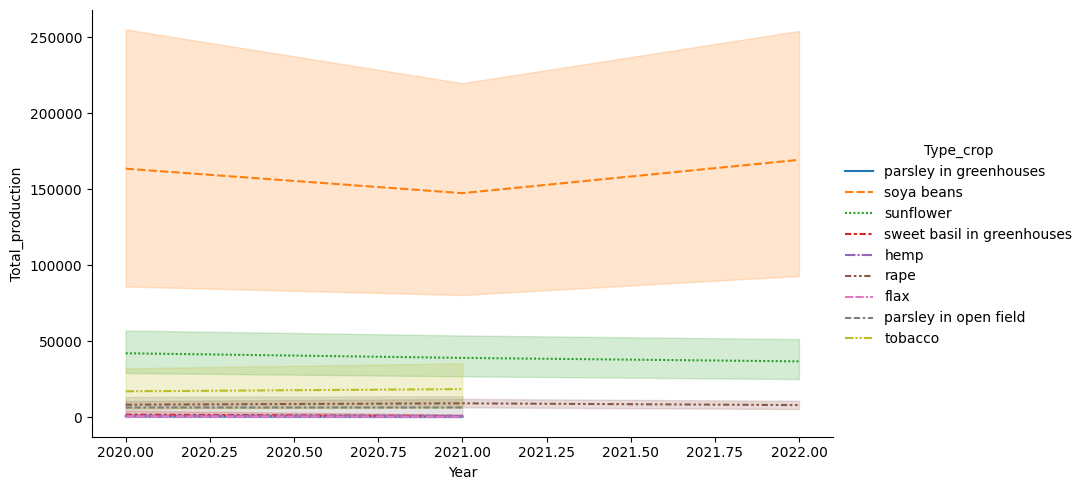

In [23]:
#Crop harvested by year
plotcrop10 = sns.relplot(kind='line', data=industrial_crop_top10, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [24]:
# Select year 2020 for future join with fertilizer
industrial_crop2020 = industrial_crop_top10[industrial_crop_top10['Year'] == 2020]
industrial_crop2020



,City,Type_crop,Year,Total_production
0,Cuneo,parsley in greenhouses,2020,350
6,Varese,parsley in greenhouses,2020,5
9,Lecco,parsley in greenhouses,2020,300
12,Milano,parsley in greenhouses,2020,580
18,Brescia,parsley in greenhouses,2020,1250
...,...,...,...,...
3155,Foggia,tobacco,2020,7
3159,Trento,parsley in open field,2020,90
3163,Sud Sardegna,sweet basil in greenhouses,2020,606
3171,Trento,hemp,2020,50


### Create columns for each type crop 2020 

In [25]:
# Create columns for each type crop
industrial_crop2020_pivot = industrial_crop2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
industrial_crop2020_pivot

Total_production                                 \
Type_crop                             flax    hemp parsley in greenhouses   
City                 Year                                                   
Agrigento            2020              NaN     NaN                    NaN   
Alessandria          2020           1320.0  1040.0                    NaN   
Ancona               2020              NaN  2300.0                    2.0   
Arezzo               2020             40.0  6650.0                   12.0   
Ascoli Piceno        2020              NaN     NaN                    7.0   
...                                    ...     ...                    ...   
Verbano-Cusio-Ossola 2020              NaN    75.0                    NaN   
Vercelli             2020              NaN     NaN                    NaN   
Verona               2020              NaN  5160.0                 9515.0   
Vicenza              2020             40.0   600.0                    NaN   
Viterbo              2020           1150.0   215.0                    NaN   

                                                                               \
Type_crop                 parsley in open field     rape soya beans sunflower   
City                 Year                                                       
Agrigento            2020                 155.0      NaN        NaN       NaN   
Alessandria          2020                6120.0  28975.0   119245.0  177300.0   
Ancona               2020                   NaN   2070.0     4736.0  240435.0   
Arezzo               2020                 140.0  10530.0     1250.0  119700.0   
Ascoli Piceno        2020                 400.0      NaN      776.0  150659.0   
...                                         ...      ...        ...       ...   
Verbano-Cusio-Ossola 2020                   NaN      NaN      450.0       NaN   
Vercelli             2020                   NaN   4163.0    70992.0    1107.0   
Verona               2020                1080.0  21515.0   480160.0   85830.0   
Vicenza              2020                   NaN  10590.0   368080.0   14650.0   
Viterbo              2020                   NaN    550.0        NaN   16900.0   

                                                               
Type_crop                 sweet basil in greenhouses  tobacco  
City                 Year                                      
Agrigento            2020                        NaN      NaN  
Alessandria          2020                        NaN      NaN  
Ancona               2020                       15.0      NaN  
Arezzo               2020                       30.0  22164.0  
Ascoli Piceno        2020                        2.0      NaN  
...                                              ...      ...  
Verbano-Cusio-Ossola 2020                        NaN      NaN  
Vercelli             2020                        NaN      NaN  
Verona               2020                    45309.0  98106.0  
Vicenza              2020                        NaN   7559.0  
Viterbo              2020                        NaN   2699.0  

[98 rows x 9 columns]

In [26]:
# Drop level
industrial_crop2020_pivot.columns = industrial_crop2020_pivot.columns.droplevel()
industrial_crop2020_pivot

,Type_crop,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2020,NaN,NaN,NaN,155.0,NaN,NaN,NaN,NaN,NaN
Alessandria,2020,1320.0,1040.0,NaN,6120.0,28975.0,119245.0,177300.0,NaN,NaN
Ancona,2020,NaN,2300.0,2.0,NaN,2070.0,4736.0,240435.0,15.0,NaN
Arezzo,2020,40.0,6650.0,12.0,140.0,10530.0,1250.0,119700.0,30.0,22164.0
Ascoli Piceno,2020,NaN,NaN,7.0,400.0,NaN,776.0,150659.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,NaN,75.0,NaN,NaN,NaN,450.0,NaN,NaN,NaN
Vercelli,2020,NaN,NaN,NaN,NaN,4163.0,70992.0,1107.0,NaN,NaN
Verona,2020,NaN,5160.0,9515.0,1080.0,21515.0,480160.0,85830.0,45309.0,98106.0


In [27]:
industrial_crop2020_pivot = industrial_crop2020_pivot.fillna(0)
industrial_crop2020_pivot

,Type_crop,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2020,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2020,1320.0,1040.0,0.0,6120.0,28975.0,119245.0,177300.0,0.0,0.0
Ancona,2020,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
Arezzo,2020,40.0,6650.0,12.0,140.0,10530.0,1250.0,119700.0,30.0,22164.0
Ascoli Piceno,2020,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,0.0,75.0,0.0,0.0,0.0,450.0,0.0,0.0,0.0
Vercelli,2020,0.0,0.0,0.0,0.0,4163.0,70992.0,1107.0,0.0,0.0
Verona,2020,0.0,5160.0,9515.0,1080.0,21515.0,480160.0,85830.0,45309.0,98106.0


In [28]:
#Rename index
industrial_crop2020_pivot = industrial_crop2020_pivot.rename_axis(None,axis=1)
industrial_crop2020_pivot

,,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2020,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2020,1320.0,1040.0,0.0,6120.0,28975.0,119245.0,177300.0,0.0,0.0
Ancona,2020,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
Arezzo,2020,40.0,6650.0,12.0,140.0,10530.0,1250.0,119700.0,30.0,22164.0
Ascoli Piceno,2020,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2020,0.0,75.0,0.0,0.0,0.0,450.0,0.0,0.0,0.0
Vercelli,2020,0.0,0.0,0.0,0.0,4163.0,70992.0,1107.0,0.0,0.0
Verona,2020,0.0,5160.0,9515.0,1080.0,21515.0,480160.0,85830.0,45309.0,98106.0


In [29]:
# Reset index
industrial_crop2020_pivot = industrial_crop2020_pivot.reset_index()
industrial_crop2020_pivot

,City,Year,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
0,Agrigento,2020,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0
1,Alessandria,2020,1320.0,1040.0,0.0,6120.0,28975.0,119245.0,177300.0,0.0,0.0
2,Ancona,2020,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
3,Arezzo,2020,40.0,6650.0,12.0,140.0,10530.0,1250.0,119700.0,30.0,22164.0
4,Ascoli Piceno,2020,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
93,Verbano-Cusio-Ossola,2020,0.0,75.0,0.0,0.0,0.0,450.0,0.0,0.0,0.0
94,Vercelli,2020,0.0,0.0,0.0,0.0,4163.0,70992.0,1107.0,0.0,0.0
95,Verona,2020,0.0,5160.0,9515.0,1080.0,21515.0,480160.0,85830.0,45309.0,98106.0
96,Vicenza,2020,40.0,600.0,0.0,0.0,10590.0,368080.0,14650.0,0.0,7559.0


## Select industrial crop 2021


In [30]:
# Select year 2020 for future join with fertilizer
industrial_crop2021 = industrial_crop_top10[industrial_crop_top10['Year'] == 2021]
industrial_crop2021



,City,Type_crop,Year,Total_production
3,Imperia,parsley in greenhouses,2021,125
13,Milano,parsley in greenhouses,2021,500
19,Brescia,parsley in greenhouses,2021,1250
25,Cremona,parsley in greenhouses,2021,200
31,Mantova,parsley in greenhouses,2021,50
...,...,...,...,...
3160,Trento,parsley in open field,2021,90
3164,Sud Sardegna,sweet basil in greenhouses,2021,606
3172,Trento,hemp,2021,60
3176,Sud Sardegna,parsley in greenhouses,2021,1461


### Create columns for each type crop 2021

In [31]:
# Create columns for each type crop
industrial_crop2021_pivot = industrial_crop2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
industrial_crop2021_pivot

Total_production                                 \
Type_crop                             flax    hemp parsley in greenhouses   
City                 Year                                                   
Agrigento            2021              NaN     NaN                    NaN   
Alessandria          2021            320.0  3120.0                    NaN   
Ancona               2021              NaN  2300.0                    2.0   
Arezzo               2021             20.0  4200.0                   10.0   
Ascoli Piceno        2021              NaN     NaN                    7.0   
...                                    ...     ...                    ...   
Verbano-Cusio-Ossola 2021              NaN    50.0                    NaN   
Vercelli             2021              NaN     NaN                    NaN   
Verona               2021              NaN  8678.0                  250.0   
Vicenza              2021             40.0   615.0                    NaN   
Viterbo              2021           1140.0   215.0                    NaN   

                                                                               \
Type_crop                 parsley in open field     rape soya beans sunflower   
City                 Year                                                       
Agrigento            2021                 150.0      NaN        NaN       NaN   
Alessandria          2021                5280.0  26250.0   140245.0  119040.0   
Ancona               2021                   NaN   2070.0     4736.0  240435.0   
Arezzo               2021                 140.0   4050.0     2250.0  110000.0   
Ascoli Piceno        2021                 400.0      NaN      776.0  150659.0   
...                                         ...      ...        ...       ...   
Verbano-Cusio-Ossola 2021                   NaN    125.0      700.0       NaN   
Vercelli             2021                   NaN   3243.0    76356.0    1593.0   
Verona               2021                   0.0  36050.0   458670.0   52325.0   
Vicenza              2021                   NaN   7920.0   346225.0   10740.0   
Viterbo              2021                   NaN    290.0        NaN   16760.0   

                                                               
Type_crop                 sweet basil in greenhouses  tobacco  
City                 Year                                      
Agrigento            2021                        NaN      NaN  
Alessandria          2021                        NaN      NaN  
Ancona               2021                       15.0      NaN  
Arezzo               2021                       50.0  27402.0  
Ascoli Piceno        2021                        2.0      NaN  
...                                              ...      ...  
Verbano-Cusio-Ossola 2021                        NaN      NaN  
Vercelli             2021                        NaN      NaN  
Verona               2021                    11630.0  92306.0  
Vicenza              2021                      385.0   9721.0  
Viterbo              2021                        NaN   3234.0  

[97 rows x 9 columns]

In [32]:
# Drop level
industrial_crop2021_pivot.columns = industrial_crop2021_pivot.columns.droplevel()
industrial_crop2021_pivot

,Type_crop,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2021,NaN,NaN,NaN,150.0,NaN,NaN,NaN,NaN,NaN
Alessandria,2021,320.0,3120.0,NaN,5280.0,26250.0,140245.0,119040.0,NaN,NaN
Ancona,2021,NaN,2300.0,2.0,NaN,2070.0,4736.0,240435.0,15.0,NaN
Arezzo,2021,20.0,4200.0,10.0,140.0,4050.0,2250.0,110000.0,50.0,27402.0
Ascoli Piceno,2021,NaN,NaN,7.0,400.0,NaN,776.0,150659.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2021,NaN,50.0,NaN,NaN,125.0,700.0,NaN,NaN,NaN
Vercelli,2021,NaN,NaN,NaN,NaN,3243.0,76356.0,1593.0,NaN,NaN
Verona,2021,NaN,8678.0,250.0,0.0,36050.0,458670.0,52325.0,11630.0,92306.0


In [33]:
industrial_crop2021_pivot = industrial_crop2021_pivot.fillna(0)
industrial_crop2021_pivot

,Type_crop,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2021,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2021,320.0,3120.0,0.0,5280.0,26250.0,140245.0,119040.0,0.0,0.0
Ancona,2021,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
Arezzo,2021,20.0,4200.0,10.0,140.0,4050.0,2250.0,110000.0,50.0,27402.0
Ascoli Piceno,2021,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2021,0.0,50.0,0.0,0.0,125.0,700.0,0.0,0.0,0.0
Vercelli,2021,0.0,0.0,0.0,0.0,3243.0,76356.0,1593.0,0.0,0.0
Verona,2021,0.0,8678.0,250.0,0.0,36050.0,458670.0,52325.0,11630.0,92306.0


In [34]:
#Rename index
industrial_crop2021_pivot = industrial_crop2021_pivot.rename_axis(None,axis=1)
industrial_crop2021_pivot

,,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
City,Year,,,,,,,,,
Agrigento,2021,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0
Alessandria,2021,320.0,3120.0,0.0,5280.0,26250.0,140245.0,119040.0,0.0,0.0
Ancona,2021,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
Arezzo,2021,20.0,4200.0,10.0,140.0,4050.0,2250.0,110000.0,50.0,27402.0
Ascoli Piceno,2021,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
Verbano-Cusio-Ossola,2021,0.0,50.0,0.0,0.0,125.0,700.0,0.0,0.0,0.0
Vercelli,2021,0.0,0.0,0.0,0.0,3243.0,76356.0,1593.0,0.0,0.0
Verona,2021,0.0,8678.0,250.0,0.0,36050.0,458670.0,52325.0,11630.0,92306.0


In [35]:
# Reset index
industrial_crop2021_pivot = industrial_crop2021_pivot.reset_index()
industrial_crop2021_pivot

,City,Year,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco
0,Agrigento,2021,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0
1,Alessandria,2021,320.0,3120.0,0.0,5280.0,26250.0,140245.0,119040.0,0.0,0.0
2,Ancona,2021,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0
3,Arezzo,2021,20.0,4200.0,10.0,140.0,4050.0,2250.0,110000.0,50.0,27402.0
4,Ascoli Piceno,2021,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
92,Verbano-Cusio-Ossola,2021,0.0,50.0,0.0,0.0,125.0,700.0,0.0,0.0,0.0
93,Vercelli,2021,0.0,0.0,0.0,0.0,3243.0,76356.0,1593.0,0.0,0.0
94,Verona,2021,0.0,8678.0,250.0,0.0,36050.0,458670.0,52325.0,11630.0,92306.0
95,Vicenza,2021,40.0,615.0,0.0,0.0,7920.0,346225.0,10740.0,385.0,9721.0


### Pre-process fertilizers dataset 

In [36]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [37]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [38]:
#fertilizer.Territory.unique()

In [39]:
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [40]:
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


## Select fertilizers 2020

In [41]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


In [42]:
#fertilizer2020.Type_fertilizer.unique()

In [43]:
#print(fertilizer2020.Type_fertilizer.max())
#print(fertilizer2020.Type_fertilizer.value_counts())
#print(fertilizer2020.Type_fertilizer.nunique())

In [44]:
fertilizer2020 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2020.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


In [45]:
# Create columns for each type of fertilizer 
fertilizer2020_pivot = fertilizer2020.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2020_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [46]:
# Drop level
fertilizer2020_pivot.columns = fertilizer2020_pivot.columns.droplevel()
fertilizer2020_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [47]:
#Rename index
fertilizer2020_pivot = fertilizer2020_pivot.rename_axis(None,axis=1)
fertilizer2020_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [48]:
# Reset index
fertilizer2020_pivot = fertilizer2020_pivot.reset_index()
fertilizer2020_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


In [49]:
# Join both datasets 
it_crop_ferlizer2020 = pd.merge(industrial_crop2020_pivot, fertilizer2020_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer2020


,City,Year,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,0.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0,155.0,12.0,1715.0,4006.0,142.0,16.0
1,Alessandria,2020,1320.0,1040.0,0.0,6120.0,28975.0,119245.0,177300.0,0.0,0.0,135.0,105.0,20968.0,2251.0,782.0,743.0
2,Ancona,2020,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0,567.0,17.0,22511.0,2695.0,1258.0,33.0
3,Arezzo,2020,40.0,6650.0,12.0,140.0,10530.0,1250.0,119700.0,30.0,22164.0,68.0,26.0,3675.0,2053.0,72.0,209.0
4,Ascoli Piceno,2020,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0,8.0,158.0,1065.0,1284.0,22.0,267.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Verbano-Cusio-Ossola,2020,0.0,75.0,0.0,0.0,0.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0
94,Vercelli,2020,0.0,0.0,0.0,0.0,4163.0,70992.0,1107.0,0.0,0.0,14.0,2570.0,7604.0,6585.0,0.0,1013.0
95,Verona,2020,0.0,5160.0,9515.0,1080.0,21515.0,480160.0,85830.0,45309.0,98106.0,3919.0,258.0,66460.0,9529.0,9363.0,6141.0
96,Vicenza,2020,40.0,600.0,0.0,0.0,10590.0,368080.0,14650.0,0.0,7559.0,1350.0,225.0,10182.0,1252.0,220.0,351.0


## Select fertilizers 2021

In [50]:
# Select year 2020 for future join with fertilizer
fertilizer2021 = fertilizer[fertilizer['Year'] == 2021]
fertilizer2021

,City,Type_fertilizer,Year,Fertilizers_tonnes
2,Rimini,containing micronutrients,2021,3
5,Trieste,peaty soil amendment,2021,0
8,Pisa,specific action products,2021,33
11,Pordenone,three components - nitrogen-phosphorous-phosph...,2021,8286
14,Venezia,soil correctives - sulphur for agricultural use,2021,95
...,...,...,...,...
17662,Sud Sardegna,soil correctives - other soil correctives,2021,4
17665,Sud Sardegna,crop substrates,2021,40
17668,Sud Sardegna,specific action products,2021,736
17671,Sud Sardegna,specific action products -,2021,543


In [51]:
#fertilizer2021.Type_fertilizer.unique()

In [52]:
#print(fertilizer2021.Type_fertilizer.max())
#print(fertilizer2021.Type_fertilizer.value_counts())
#print(fertilizer2021.Type_fertilizer.nunique())

In [53]:
fertilizer2021 = fertilizer2021.apply(lambda row: row[fertilizer2021['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer2021.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
77,Pavia,ammonium sulphate,2021,2504
155,Benevento,calcium cyanamide,2021,0
167,Treviso,ammonium sulphate,2021,1541
173,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2021,28
236,Alessandria,organic fertilizers,2021,3930


In [54]:
# Create columns for each type of fertilizer 
fertilizer2021_pivot = fertilizer2021.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer2021_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2021                738                12                 4592   
Alessandria   2021                151               105                21951   
Ancona        2021                954                17                14630   
Arezzo        2021                 32                27                 2414   
Ascoli Piceno 2021                  3               158                 1610   
...                               ...               ...                  ...   
Vercelli      2021                  5              2571                 8929   
Verona        2021               7632               258                59389   
Vibo Valentia 2021                518                 0                 1498   
Vicenza       2021               1784               226                 6690   
Viterbo       2021                152                 0                11245   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2021                3668                   1075   
Alessandria   2021                3930                    900   
Ancona        2021                2500                   1809   
Arezzo        2021                2174                     71   
Ascoli Piceno 2021                1211                      8   
...                                ...                    ...   
Vercelli      2021                8312                    225   
Verona        2021               10023                  12968   
Vibo Valentia 2021                  61                    185   
Vicenza       2021                1634                   1100   
Viterbo       2021                2199                    587   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2021                    36  
Alessandria   2021                   713  
Ancona        2021                    43  
Arezzo        2021                     8  
Ascoli Piceno 2021                    46  
...                                  ...  
Vercelli      2021                  1014  
Verona        2021                 10878  
Vibo Valentia 2021                     0  
Vicenza       2021                   382  
Viterbo       2021                    11  

[108 rows x 6 columns]

In [55]:
# Drop level
fertilizer2021_pivot.columns = fertilizer2021_pivot.columns.droplevel()
fertilizer2021_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [56]:
#Rename index
fertilizer2021_pivot = fertilizer2021_pivot.rename_axis(None,axis=1)
fertilizer2021_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2021,738,12,4592,3668,1075,36
Alessandria,2021,151,105,21951,3930,900,713
Ancona,2021,954,17,14630,2500,1809,43
Arezzo,2021,32,27,2414,2174,71,8
Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...
Vercelli,2021,5,2571,8929,8312,225,1014
Verona,2021,7632,258,59389,10023,12968,10878
Vibo Valentia,2021,518,0,1498,61,185,0


In [57]:
# Reset index
fertilizer2021_pivot = fertilizer2021_pivot.reset_index()
fertilizer2021_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,738,12,4592,3668,1075,36
1,Alessandria,2021,151,105,21951,3930,900,713
2,Ancona,2021,954,17,14630,2500,1809,43
3,Arezzo,2021,32,27,2414,2174,71,8
4,Ascoli Piceno,2021,3,158,1610,1211,8,46
...,...,...,...,...,...,...,...,...
103,Vercelli,2021,5,2571,8929,8312,225,1014
104,Verona,2021,7632,258,59389,10023,12968,10878
105,Vibo Valentia,2021,518,0,1498,61,185,0
106,Vicenza,2021,1784,226,6690,1634,1100,382


In [58]:
# Join both datasets 
it_crop_ferlizer2021 = pd.merge(industrial_crop2021_pivot, fertilizer2021_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer2021


,City,Year,flax,hemp,parsley in greenhouses,parsley in open field,rape,soya beans,sunflower,sweet basil in greenhouses,tobacco,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2021,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,738.0,12.0,4592.0,3668.0,1075.0,36.0
1,Alessandria,2021,320.0,3120.0,0.0,5280.0,26250.0,140245.0,119040.0,0.0,0.0,151.0,105.0,21951.0,3930.0,900.0,713.0
2,Ancona,2021,0.0,2300.0,2.0,0.0,2070.0,4736.0,240435.0,15.0,0.0,954.0,17.0,14630.0,2500.0,1809.0,43.0
3,Arezzo,2021,20.0,4200.0,10.0,140.0,4050.0,2250.0,110000.0,50.0,27402.0,32.0,27.0,2414.0,2174.0,71.0,8.0
4,Ascoli Piceno,2021,0.0,0.0,7.0,400.0,0.0,776.0,150659.0,2.0,0.0,3.0,158.0,1610.0,1211.0,8.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Verbano-Cusio-Ossola,2021,0.0,50.0,0.0,0.0,125.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0
93,Vercelli,2021,0.0,0.0,0.0,0.0,3243.0,76356.0,1593.0,0.0,0.0,5.0,2571.0,8929.0,8312.0,225.0,1014.0
94,Verona,2021,0.0,8678.0,250.0,0.0,36050.0,458670.0,52325.0,11630.0,92306.0,7632.0,258.0,59389.0,10023.0,12968.0,10878.0
95,Vicenza,2021,40.0,615.0,0.0,0.0,7920.0,346225.0,10740.0,385.0,9721.0,1784.0,226.0,6690.0,1634.0,1100.0,382.0


### Correlation 2020

In [59]:

crop = it_crop_ferlizer2020.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2020['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer2020[['City','sunflower', 'rape', 'soya beans',
                                 'hemp', 'parsley in open field','sweet basil in greenhouses',
                                 'parsley in greenhouses', 'tobacco', 'flax','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

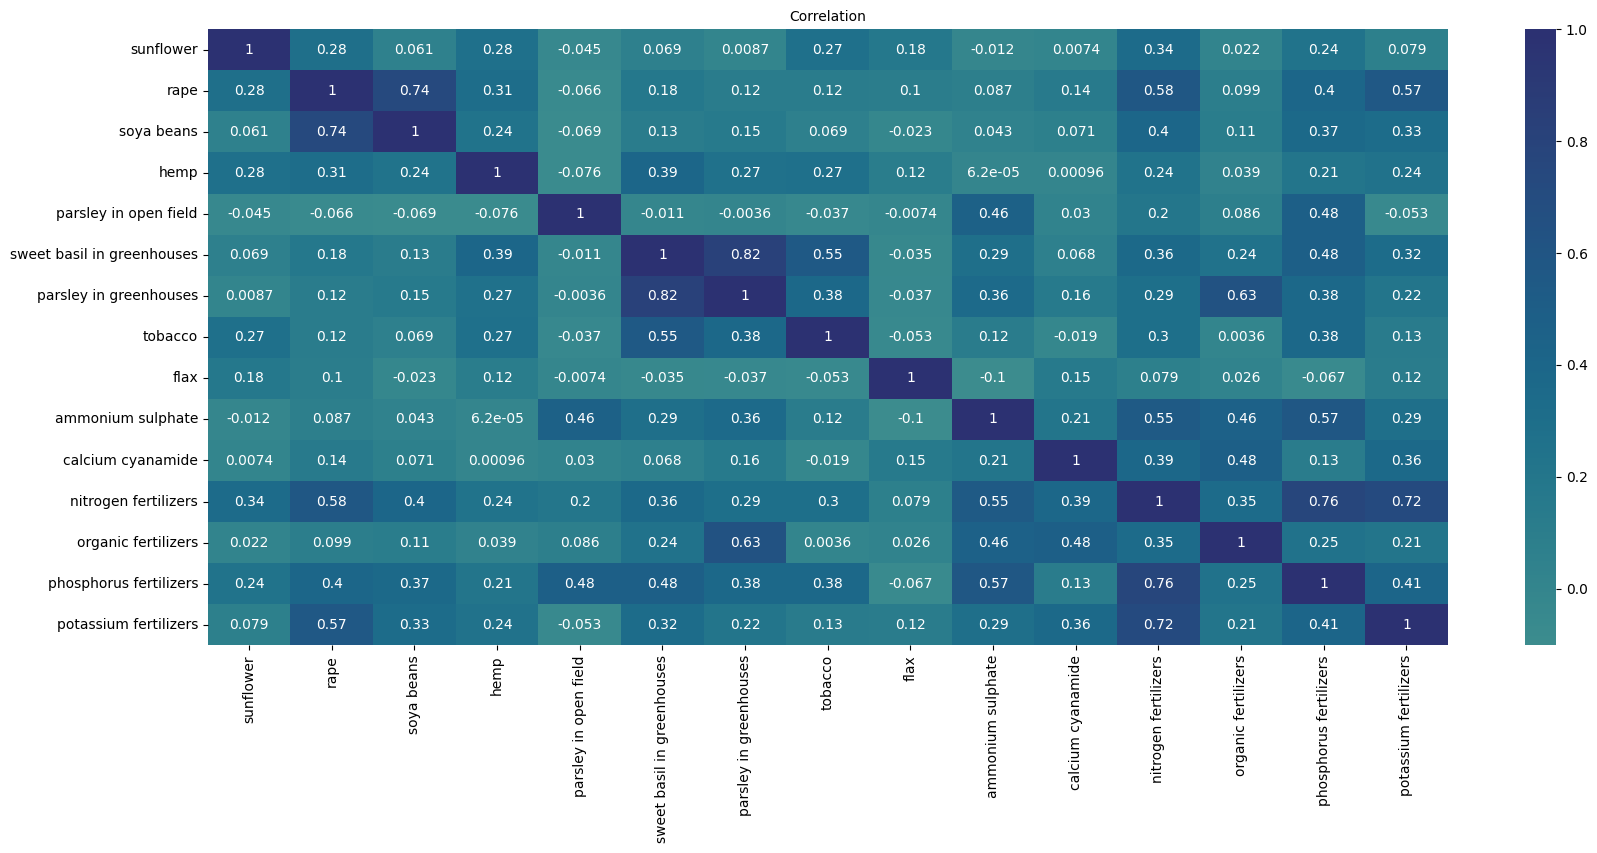

In [60]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of industrial crop production in Italy 2020 

* Sunflower has correlation nitrogen fertilizer.

* Rape has high correlation with Soya, potassium, nitrogen and phosphorus fertilizers.

* Hemp has low correlation with fertilizers and other crops.

* Pasley in the field has high correlation with ammonium sulphate and phosphorus fertilizers.

* Pasley in greenhouses has high correlation with organic fertilizer ans Basil.

* Tobacco has high correlation with Basil.

* Flax have low correlation with fertilizers and other crops.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


In [61]:

crop = it_crop_ferlizer2021.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer2021['target']=crop.cat.codes

#y = it_crop_ferliser.Type_crop
cor_selected = it_crop_ferlizer2021[['City','sunflower', 'rape', 'soya beans',
                                 'hemp', 'parsley in open field','sweet basil in greenhouses',
                                 'parsley in greenhouses', 'tobacco', 'flax','ammonium sulphate',
                                 'calcium cyanamide','nitrogen fertilizers', 'organic fertilizers',
                                 'phosphorus fertilizers','potassium fertilizers']] 


<AxesSubplot: title={'center': 'Correlation'}>

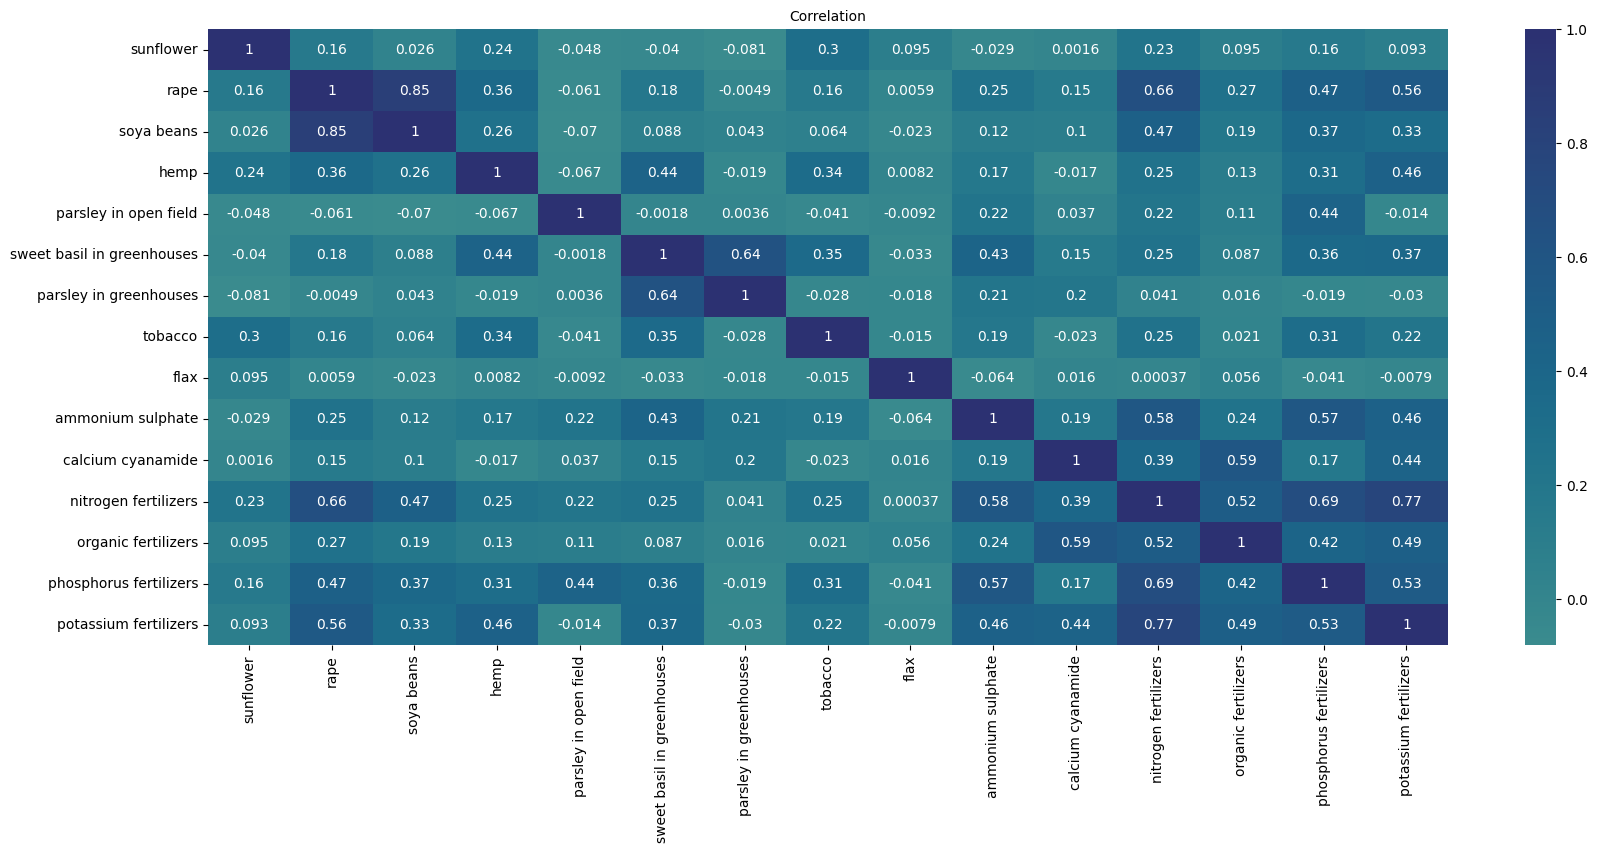

In [62]:
plt.figure(figsize=(20,8))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of industrial crop production in Italy 2021

* Sunflower has low correlation with fertilizer and other industrial crops.

* Rape has high correlation with potassium, nitrogen and phosphorus fertilizers and Soya beans.

* Soya beans has high correlation with Rape.

* Hemp has correlation with potassium fertilizers and Basil.

* Basil has high correlation with Pasley in greenhouses.

* Tobacco and Flax have low correlation with fertilizers and other crops.

* There is also hight correlation between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html